# Implementing the U-Net Architecture
The paper uses a U-Net architecture for doing the image inpainting. We've implemented this in `libs/unet.py` module, and we will review it here.

In [10]:
import sys
sys.path.append("../libs/")

In [11]:
from copy import deepcopy
import cv2
import numpy as np

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.layers.merge import Concatenate

import matplotlib
import matplotlib.pyplot as plt

from util import random_mask
from pconv import PartialConvolution2D
%matplotlib inline

In [12]:
class PConvUnet(object):

    def __init__(self, img_rows=256, img_cols=256):
        """Create the PConvUnet. If variable image size, set img_rows and img_cols to None"""
        
        # Settings
        self.img_rows = img_rows
        self.img_cols = img_cols
        
        # Create model
        self.model = self.get_model()

    def get_model(self):
        print(">> Now creating U-Net Model")
        inputs = Input((self.img_rows, self.img_cols,3))

        # Encoder
        conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
        conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
        conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
        conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
        conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
        
        conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
        conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
        pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)
        
        conv6 = Conv2D(512, 3, activation='relu', padding='same')(pool5)
        conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
        pool6 = MaxPooling2D(pool_size=(2, 2))(conv6)
        
        conv7 = Conv2D(512, 3, activation='relu', padding='same')(pool6)
        conv7 = Conv2D(512, 3, activation='relu', padding='same')(conv7)
        drop7 = Dropout(0.5)(conv7)
        pool7 = MaxPooling2D(pool_size=(2, 2))(drop7)

        # Center layer
        conv8 = Conv2D(512, 3, activation='relu', padding='same')(pool7)
        conv8 = Conv2D(512, 3, activation='relu', padding='same')(conv8)
        drop8 = Dropout(0.5)(conv8)

        # Decoder
        up9 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size = (2,2))(drop8))
        merge9 = Concatenate(axis=3)([drop7,up9])
        conv9 = Conv2D(512, 3, activation='relu', padding='same')(merge9)
        conv9 = Conv2D(512, 3, activation='relu', padding='same')(conv9)

        up10 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size = (2,2))(conv9))
        merge10 = Concatenate(axis=3)([conv6,up10])
        conv10 = Conv2D(512, 3, activation='relu', padding='same')(merge10)
        conv10 = Conv2D(512, 3, activation='relu', padding='same')(conv10)

        up11 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size = (2,2))(conv10))
        merge11 = Concatenate(axis=3)([conv5,up11])
        conv11 = Conv2D(512, 3, activation='relu', padding='same')(merge11)
        conv11 = Conv2D(512, 3, activation='relu', padding='same')(conv11)
        
        up11 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size = (2,2))(conv10))
        merge11 = Concatenate(axis=3)([conv5,up11])
        conv11 = Conv2D(512, 3, activation='relu', padding='same')(merge11)
        conv11 = Conv2D(512, 3, activation='relu', padding='same')(conv11)
        
        up12 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size = (2,2))(conv11))
        merge12 = Concatenate(axis=3)([conv4,up12])
        conv12 = Conv2D(256, 3, activation='relu', padding='same')(merge12)
        conv12 = Conv2D(256, 3, activation='relu', padding='same')(conv12)
        
        up13 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size = (2,2))(conv12))
        merge13 = Concatenate(axis=3)([conv3,up13])
        conv13 = Conv2D(128, 3, activation='relu', padding='same')(merge13)
        conv13 = Conv2D(128, 3, activation='relu', padding='same')(conv13)
        
        up14 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size = (2,2))(conv13))
        merge14 = Concatenate(axis=3)([conv2,up14])
        conv14 = Conv2D(64, 3, activation='relu', padding='same')(merge14)
        conv14 = Conv2D(64, 3, activation='relu', padding='same')(conv14)
        
        up15 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size = (2,2))(conv14))
        merge15 = Concatenate(axis=3)([conv1,up15])
        conv15 = Conv2D(64, 3, activation='relu', padding='same')(merge15)
        conv15 = Conv2D(64, 3, activation='relu', padding='same')(conv15)
        conv15 = Conv2D(3, 1, activation = 'sigmoid')(conv15)
        
        model = Model(inputs=inputs, outputs=conv15)
        model.compile(
            optimizer = Adam(lr = 1e-4),
            loss='binary_crossentropy'
        )

        return model


    def fit(self, generator, epochs=10, test_imgs=None, *args, **kwargs):
        """Fit the U-Net to a (images, targets) generator
        
        param generator: training generator yielding (original_img, mask) tuples
        param epochs: number of epochs to train for
        param test_imgs: list of (masked_img, original_img) tuples to test each epoch
        """
        
        # Loop over epochs
        for i in range(epochs):
            print(f">> Fitting epoch {i+1}")
            
            # Fit the model
            self.model.fit_generator(
                generator,
                epochs=i+1,
                initial_epoch=i,
                *args, **kwargs
            )
            
            # After each epoch predict on test images & show them
            for test in test_imgs:
                
                mask_img, ori_img = test
                pred_img = model.predict(mask_img)

                _, axes = plt.subplots(1, 3, figsize=(20, 5))
                axes[0].imshow(mask_img[0,:,:,:])
                axes[1].imshow(pred_img[0,:,:,:])
                axes[2].imshow(ori_img[0,:,:,:])
                axes[0].set_title('Masked Image')
                axes[1].set_title('Predicted Image')
                axes[2].set_title('Original Image')
                plt.show()
            
    def predict(self, sample):
        return self.model.predict(sample)
                        
    def save_img(self):
        print(">> Saving test images")
        imgs = np.load('imgs_mask_test.npy')
        for i in range(imgs.shape[0]):
            img = imgs[i]
            img = array_to_img(img)
            img.save("../results/%d.jpg"%(i))       
            
test = PConvUnet()
test.model.summary()

>> Now creating U-Net Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
_________________________________________________________________________________

# Testing out on single image

Shape of image is: (256, 256, 3)


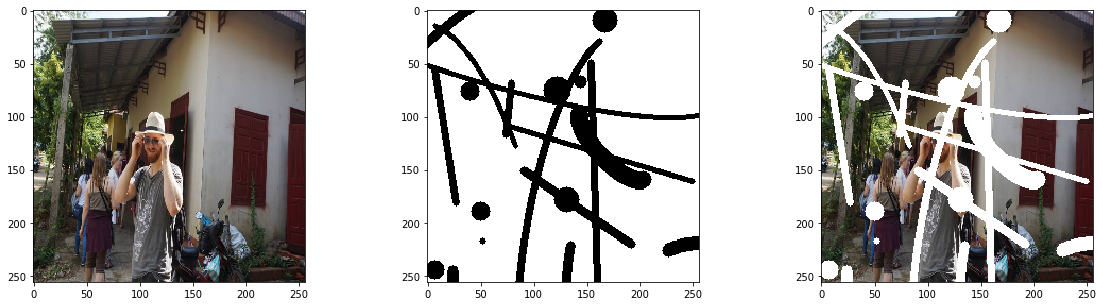

In [13]:
# Load image
img = cv2.imread('../data/sample_image.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256)) / 255
shape = img.shape
print(f"Shape of image is: {shape}")

# Load mask
mask = random_mask(shape[0], shape[1])

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask, cmap = 'gray')
axes[2].imshow(masked_img)
plt.show()

## Creating data generator
In this simple testing case we'll only be testing the architecture on a single image to see how it performs. We create a generator that will infinitely yield the same image and masked_image for us.

In [29]:
class DataGenerator(object):
    """Simple data generator that keeps feeding the same image"""
    def __init__(self, masked_image, original_image):
        # Add batch dimension to images
        self.masked_image = np.expand_dims(masked_image, 0)
        self.original_image = np.expand_dims(original_image, 0)
    def __next__(self):
        return self.masked_image, self.original_image
    def __iter__(self):
        return self   

# Create a generator
datagen = DataGenerator(masked_img, img)

## Training classifier on single image

In [ ]:
model = PConvUnet()
model.fit(
    datagen, 
    steps_per_epoch=1000,
    epochs=10,
    test_imgs=[next(datagen)]
)

>> Now creating U-Net Model
>> Fitting epoch 1
Epoch 1/1
  40/1000 [>.............................] - ETA: 1:05:22 - loss: 0.6609